## Human Protein Multi Label Image Classification 

This is a starter notebook for the competition [Zero to GANs - Human Protein Classification](https://www.kaggle.com/c/jovian-pytorch-z2g)

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import pandas as pd
import time
import copy
%matplotlib inline

## Exploring the Data

Let us create some constants acess the data directories and CSV files.

In [ ]:
DATA_DIR = '../Human protein atlas'                       # Add the data path

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = 'jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

The `train.csv` file contains image IDs and labels for training data. Note that this is a multi-label classification problem. Each image can have more than one type of protein.

In [ ]:

!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


Similarly, `submission.csv` contains image IDs for test data. However, since the goal of this competition is to make predictions for the test set, the `submission.csv` files contains **dummy labels**, which you need to replace with your predictions and sumbit to the competition on the "Submission" tab. In other words, we don't have the labels for the test set.

In [ ]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


The image files are named `<image-id>.png` and can be found in the respective `train` and `test` folders.

In [ ]:
!ls "{TRAIN_DIR}" | head

0.png
1.png
10000.png
10001.png
10005.png
10008.png
10009.png
10012.png
10013.png
10014.png
ls: write error: Broken pipe


Let's load the `train.csv` file into a Pandas dataframe

In [ ]:
df = pd.read_csv(TRAIN_CSV)
df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


## Stratified sampling to solve imblance class

In [ ]:
cat= df['Label'].value_counts()

In [ ]:
cat = cat.to_frame()
cat.reset_index(inplace=True)
cat.rename(columns={'index':'Label', 'Label':'Count'},inplace=True)

### 1. **Categorize them relavent to their precentage in load training datastet**

In [ ]:
cat['Category'] = np.ceil(cat['Count'] / len(df) *100)

cat['Category'].value_counts()

1.0     105
2.0       7
5.0       5
3.0       4
4.0       2
7.0       1
9.0       1
10.0      1
15.0      1
Name: Category, dtype: int64

In [ ]:
cat.drop(['Count'], axis=1,inplace=True)

In [ ]:
df = df.merge(cat, on='Label', how='left')

In [ ]:
df.head()

,Image,Label,Category
0,19567,9,5.0
1,29993,6 4,10.0
2,17186,1 4,2.0
3,29600,6 2,2.0
4,701,3 4,3.0


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

In [ ]:
for train_index, val_index in split.split(df[['Image','Label']], df["Category"]):
    train_df = df[['Image','Label']].loc[train_index]
    val_df = df[['Image','Label']].loc[val_index]


In [ ]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df

,Image,Label
0,11540,4 7
1,24548,7
2,25271,6 7
3,16159,0 5 4
4,7223,6
...,...,...
17307,23229,9
17308,27602,7
17309,2402,6 7
17310,22628,8


## Creating Datasets & Data Loaders

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [ ]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [ ]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)
    

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are `'2 4 5'`, the correspoding vector for it would be `[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]`. Let's define helper funtions to encode labels into tensors and vice versa.

In [ ]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

Transforms can be chained using `transforms.Compose`. For instance, you may add `transforms.Resize(128)` before `transforms.ToTensor()` to resize images to size 128x128 before converting them into tensors. See the full list of transforms here: https://pytorch.org/docs/master/torchvision/transforms.html

In [ ]:
normalize_stats = ([0.0793, 0.0530, 0.0545], [0.1290, 0.0886, 0.1376])

train_tfms = T.Compose([
    T.RandomCrop(512),
    T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
     T.Normalize(*normalize_stats,inplace=True), 
  #  T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize(256), 
    T.ToTensor(), 
     T.Normalize(*normalize_stats)
])

In [ ]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)

In [ ]:
len(train_ds),len(val_ds)

(17312, 1924)

In [ ]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

Let's take a look at a sample image from the dataset. We'll define a function `show_sample` to help us. We will also include the option to invert the image before showing it, because the original images are quite dark.

In [ ]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Here's a sample image without the colors inverted.

Labels: Nucleoplasm(4)


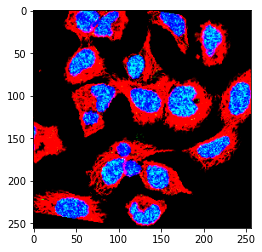

In [ ]:
show_sample(*train_ds[1541], invert=False)

Here's the same image viewed with the colors inverted

Labels: Nucleoplasm(4)


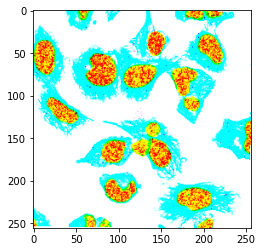

In [ ]:
show_sample(*train_ds[1541])

### Training & Validation sets

As a good practice, we should split the data into training and validation datasets. Let's fix a seed for PyTorch (to ensure we always get the same validation set), and create the datasets using `random_split`.

In [ ]:
torch.manual_seed(10)

### Data Loaders

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

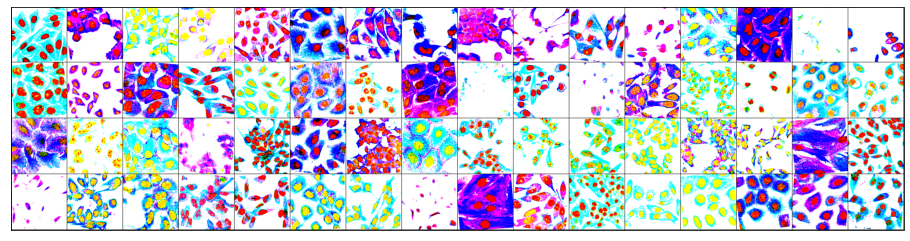

In [ ]:
show_batch(train_dl)

## Model

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score'], result['val_score']))

In [ ]:
class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torch.load('zero2gans/resnet101_final.pth')
        # Replace last layer
        
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
        

### Load Pretrained model

In [ ]:
model = ProteinCnnModel2()
model

ProteinCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = 'cuda'

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

If your kernel runs out of memory here, you might need to reduce your batch size.

## Training the model

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    since = time.time()
    
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func
    best_model_wts = copy.deepcopy(model.network.state_dict())
    best_acc = evaluate(model, val_loader)['val_score']
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        if result['val_score'] > best_acc:
            best_acc = result['val_score']
            best_model_wts = copy.deepcopy(model.network.state_dict())
        
        model.epoch_end(epoch, result)
        
        history.append(result)
    
    model.network.state_dict(best_model_wts)
    
    time_elapsed = time.time() - since
    
    print('Training has completed in {:.0f}m {:.0f}s => '.format(time_elapsed // 60, time_elapsed % 60), end=' ')
    
    print("\nBest_score {:.4f}".format(best_acc))
    
    return history

In [ ]:
model.network.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
evaluate(model, val_dl)

{'val_loss': 0.14211833477020264, 'val_score': 0.822634220123291}

In [ ]:
num_epochs = 20
opt_func = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-6)

In [ ]:
history = fit(num_epochs, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.1484, val_loss: 0.1439, val_score: 0.8218



Epoch [1], train_loss: 0.1494, val_loss: 0.1444, val_score: 0.8217



Epoch [2], train_loss: 0.1486, val_loss: 0.1446, val_score: 0.8222



Epoch [3], train_loss: 0.1486, val_loss: 0.1442, val_score: 0.8220



Epoch [4], train_loss: 0.1486, val_loss: 0.1439, val_score: 0.8243



Epoch [5], train_loss: 0.1490, val_loss: 0.1436, val_score: 0.8218



Epoch [6], train_loss: 0.1485, val_loss: 0.1426, val_score: 0.8254



Epoch [7], train_loss: 0.1482, val_loss: 0.1428, val_score: 0.8225



Epoch [8], train_loss: 0.1475, val_loss: 0.1449, val_score: 0.8202



Epoch [9], train_loss: 0.1490, val_loss: 0.1429, val_score: 0.8244



Epoch [10], train_loss: 0.1482, val_loss: 0.1424, val_score: 0.8273



Epoch [11], train_loss: 0.1474, val_loss: 0.1422, val_score: 0.8247



Epoch [12], train_loss: 0.1485, val_loss: 0.1439, val_score: 0.8214



Epoch [13], train_loss: 0.1478, val_loss: 0.1426, val_score: 0.8241



Epoch [14], train_loss: 0.1482, val_loss: 0.1418, val_score: 0.8254



Epoch [15], train_loss: 0.1478, val_loss: 0.1425, val_score: 0.8238



Epoch [16], train_loss: 0.1474, val_loss: 0.1420, val_score: 0.8271



Epoch [17], train_loss: 0.1478, val_loss: 0.1417, val_score: 0.8246



Epoch [18], train_loss: 0.1477, val_loss: 0.1433, val_score: 0.8213



Epoch [19], train_loss: 0.1478, val_loss: 0.1426, val_score: 0.8248
Training has completed in 87m 44s =>  
Best_score 0.8273


In [ ]:
torch.save(model.network,"resnet101_final_02.pth")

## History Plot

In [ ]:
def plot_history(history):
    
    train_loss_total = []
    val_loss_total = []
    f1_score_total = []
    total_epochs = 0

    for hist in history:
        train_loss_total.append(hist['train_loss'])
        val_loss_total.append(hist['val_loss'])
        f1_score_total.append(hist['val_score'])
        total_epochs += 1
        
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(range(total_epochs), train_loss_total, label='Train Loss')
    axs[0].plot(range(total_epochs), val_loss_total, label='Val Loss')
    
    axs[0].legend()
    axs[0].set_title('Loss with Epochs')
    axs[1].plot(range(total_epochs), f1_score_total)  
    axs[1].set_title('F1 sore with Epochs')
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=3)
    
    
    
    

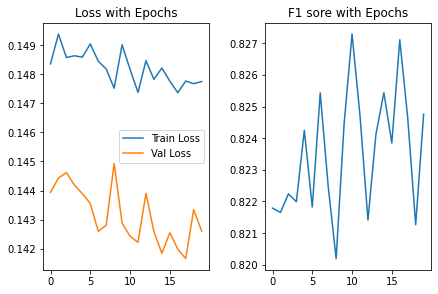

In [ ]:
plot_history(history)

## Making predictions & submission

To start with, let's create a helper function to make a prediction on a single image.

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)
img, target = test_dataset[0]
img.shape

torch.Size([3, 256, 256])

Prediction:  tensor([4.1917e-03, 2.6445e-03, 2.9187e-01, 4.7214e-03, 9.9656e-01, 1.0980e-03,
        9.6480e-01, 7.9948e-03, 7.3606e-04, 2.9408e-05], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


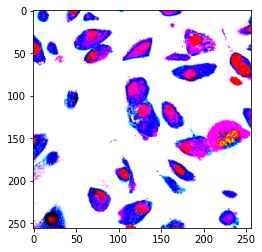

In [ ]:
predict_single(test_dataset[100][0])

Prediction:  tensor([9.6701e-01, 4.6288e-04, 4.9392e-04, 2.8804e-02, 6.5692e-02, 2.2554e-04,
        1.1223e-02, 5.4030e-04, 9.1072e-03, 1.4596e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


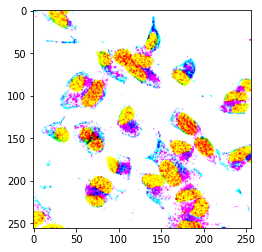

In [ ]:
predict_single(test_dataset[74][0])

Next, let's create a test dataset using the `submission.csv` file. Note that the file contains dummy labels (always `'0'`). We'll use the same transforms we used for the training set.

## Creating a submission file

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

Let us know create a submission file with these predictions

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,4
1,15322,4
2,14546,6
3,8079,6
4,13192,3 4


We can now save it batck to CSV, and download the file from the sidebar (check the output folder)

In [ ]:
sub_fname = 'Final_submission.csv'

In [ ]:
submission_df.to_csv(sub_fname, index=False)